# Week 5 - Expectation Maximization and Principal Component Analysis

Learning contents:

1. Mixture of Gaussians: Expectation-Maximization
    - Display results
    - Nearest Centroid-based classification
2. Principal Component Analysis
    - Generate data
    - Apply PCA
    - Display projection

## Dependencies

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.stats import multivariate_normal, norm
from sklearn import datasets
from IPython.display import HTML

import seaborn as sns; sns.set(); sns.set_palette('bright')

## Generate Data

#### We use `iris` dataset from `sklearn` library

(<matplotlib.collections.PathCollection at 0x173f4c710>,
 <matplotlib.legend.Legend at 0x173f4f620>)

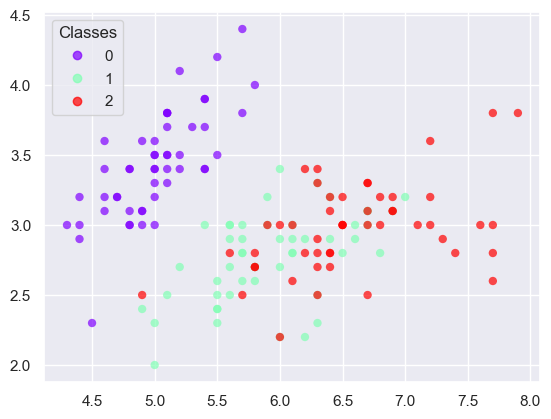

In [15]:
iris = datasets.load_iris()
iris_x = np.array(iris.data[:, :2])  # we only take the first two features.
iris_t = np.array(iris.target)

def plot_iris(legend=True, classes=iris_t, target=plt):
    scatter = target.scatter(iris_x[:, 0], iris_x[:, 1], c=classes, alpha=0.7, cmap='rainbow', edgecolor='none')
    if legend:
        legend = target.legend(*scatter.legend_elements(), loc="upper left", title="Classes")
        return (scatter, legend)
    return (scatter, )

plot_iris()

## 1) Mixture of Gaussians: Expectation-Maximization

write a function `gaussian_mixture` that takes data point `x` (say, a vector in D-dimensional space), set of multivariate `means` and respective `covariances`, and `pis` (mixing coefficients as defined in a Gaussian mixture model) and should return PDF value of mixture model at the point x.

In [16]:
def gaussian_mixture(x, means, covariances, pis):
    K = len(pis)
    p = np.zeros(x.shape[0])
    for k in range(K):
        p += pis[k] * multivariate_normal.pdf(x, mean=means[k], cov=covariances[k])
    return p

You need to implement a function:

def expectation_maximization_gaussian(mus_0, covariances_0, pis_0, data_x,
                                      max_iters=200, tol=1e-6, reg=1e-6):

where 

Inputs:

mus_0: Initial mean vectors of the Gaussian components. Shape (K, D) where K is the number of components and D is the data dimension.

covariances_0: Initial covariance matrices for each Gaussian component. Shape (K, D, D).

pis_0: Initial mixing coefficients for each component. Shape (K,). These should sum to 1.

data_x: Input dataset, shape (N, D) where N is the number of data points.

max_iters (optional): Maximum number of EM iterations to run (default 200).

tol (optional): Convergence tolerance based on the change in log-likelihood (default 1e-6).

reg (optional): Small regularization value added to the covariance diagonals to avoid singular matrices (default 1e-6).

Outputs:

steps: A list where each element corresponds to the state of the algorithm at one iteration.
Each element is a tuple:

(mus, covariances, pis, log_likelihood, predictions)


where:

mus: Updated mean vectors after that iteration (shape (K, D)).

covariances: Updated covariance matrices (shape (K, D, D)).

pis: Updated mixing coefficients (shape (K,)).

log_likelihood: The scalar log-likelihood value at that iteration.

predictions: Hard cluster assignments for each data point (shape (N,)), typically obtained by taking the argmax over posterior responsibilities.

In [17]:
def expectation_maximization_gaussian(mus_0, covariances_0, pis_0, data_x,
                                      max_iters=200, tol=1e-6, reg=1e-6):
    # Initialize parameters
    mus = mus_0.copy()
    covariances = covariances_0.copy()
    pis = pis_0.copy()
    
    N, D = data_x.shape  # N samples, D dimensions
    K = len(pis)         # K components
    
    steps = []
    prev_log_likelihood = -np.inf
    
    for iteration in range(max_iters):
        # E-step: Compute posterior responsibilities
        responsibilities = np.zeros((N, K))  # Shape: (N, K)
        
        for k in range(K):
            # Compute likelihood of each data point under component k
            try:
                # Add regularization to covariance to avoid singularity
                cov_reg = covariances[k] + reg * np.eye(D)
                responsibilities[:, k] = pis[k] * multivariate_normal.pdf(
                    data_x, mean=mus[k], cov=cov_reg
                )
            except np.linalg.LinAlgError:
                # Fallback if covariance is still singular
                responsibilities[:, k] = 1e-10
        
        # Normalize responsibilities (convert to posterior probabilities)
        total_responsibility = np.sum(responsibilities, axis=1, keepdims=True)
        total_responsibility = np.maximum(total_responsibility, 1e-10)  # Avoid division by zero
        responsibilities = responsibilities / total_responsibility
        
        # Compute log-likelihood
        log_likelihood = np.sum(np.log(total_responsibility.flatten()))
        
        # Hard cluster assignments (predictions)
        predictions = np.argmax(responsibilities, axis=1)
        
        # Store current step
        steps.append((mus.copy(), covariances.copy(), pis.copy(), log_likelihood, predictions.copy()))
        
        # Check for convergence
        if abs(log_likelihood - prev_log_likelihood) < tol:
            break
        prev_log_likelihood = log_likelihood
        
        # M-step: Update parameters
        # Effective number of points assigned to each component
        N_k = np.sum(responsibilities, axis=0)  # Shape: (K,)
        
        # Update mixing coefficients
        pis = N_k / N
        
        # Update means
        for k in range(K):
            if N_k[k] > 1e-10:  # Avoid division by zero
                mus[k] = np.sum(responsibilities[:, k:k+1] * data_x, axis=0) / N_k[k]
            
        # Update covariances
        for k in range(K):
            if N_k[k] > 1e-10:  # Avoid division by zero
                diff = data_x - mus[k]  # Shape: (N, D)
                # Weighted covariance matrix
                weighted_diff = responsibilities[:, k:k+1] * diff  # Shape: (N, D)
                covariances[k] = np.dot(weighted_diff.T, diff) / N_k[k]
                
                # Add regularization to diagonal
                covariances[k] += reg * np.eye(D)
    
    return steps

### 1.1) Display results

In [18]:
def plot_gaussian_mixtures(mus, covariances, pis, data, classes, cmap='rainbow', target=plt):
    
    lx = min(data[:, 0])
    rx = max(data[:, 0])
    by = min(data[:, 1])
    uy = max(data[:, 1])

    x, y = np.mgrid[lx:rx:.01, by:uy:.01]
    pos = np.dstack((x, y))
    
    probabilities = list(map(
        lambda x: gaussian_mixture(x, mus, covariances, pis),
        pos
    ))
    
    target.contour(x, y, probabilities, cmap=cmap)
    
    plot = plot_iris(classes=classes, target=target)
    # scatter = target.scatter(mus[:, 0], mus[:, 1], c=[0, 1, 2], cmap='rainbow', marker='data', s=300, edgecolors='black')
    return (*plot, )


def plot_mesh(pred_fn, n_class=3, x_min=4, x_max=8, y_min=2, y_max=4.5, target=plt):
    h = 0.1  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = np.array(list(map(lambda x: pred_fn(np.array(x)), np.c_[xx.ravel(), yy.ravel()])))
    Z = Z.reshape(xx.shape)
    cs = target.contourf(xx, yy, Z, alpha = 0.1, cmap=plt.cm.get_cmap('rainbow', n_class))
    target.axis('tight')
    if hasattr(target, 'xlim'):
        target.xlim(x_min, x_max)
        target.ylim(y_min, y_max)

Here, we define our initial means `mus_0`, covariance matrices `covariances_0`, mixing coefficient values `pis_0` and call the `expectation_maximization_gaussian function`. 

In [19]:
np.random.seed(26)

classes = 3

all_steps_em = []

mus_0 = iris_x[:classes]
covariances_0 = np.array([np.cov(iris_x.T)] * classes)
pis_0 = np.array([1/classes] * classes)

all_steps_em = expectation_maximization_gaussian(
    mus_0, covariances_0, pis_0, iris_x, max_iters=100
)

The function create_animation() is provided for you.
It takes the results of your expectation_maximization_gaussian() implementation and produces an animation. The animation shows how the Gaussian components (means and covariance ellipses) evolve on top of the original dataset, while also plotting the log-likelihood progression over the iterations.

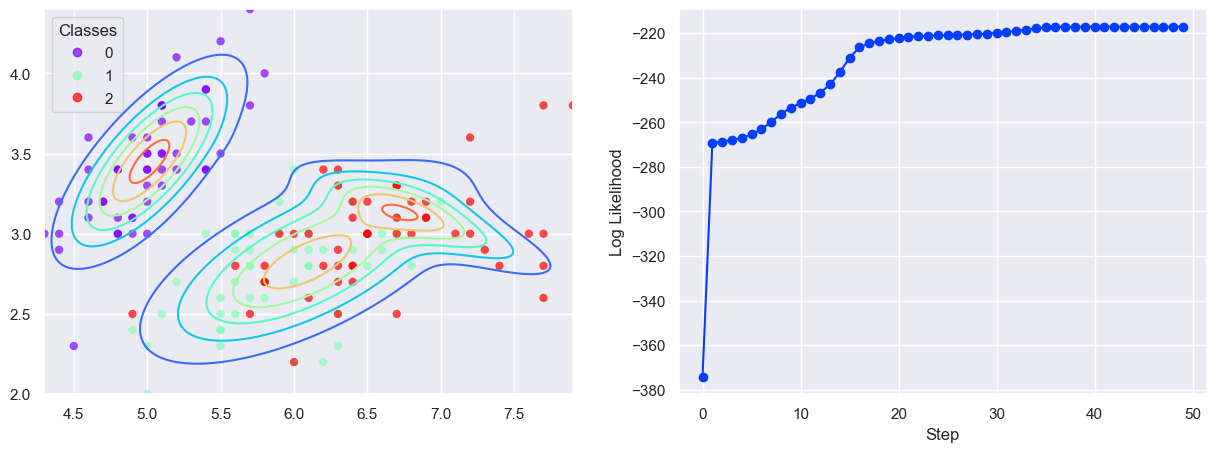

In [20]:
def create_animation(all_steps_em, data_x,iris_t):
    
    fig, (ax, ax2) = plt.subplots(1, 2, figsize=(15,5))
    
    log_likelihoods = list(map(lambda x: x[3], all_steps_em))
    
    def animate(i):
        ax.cla()
        ax2.cla()
        
        predictions = all_steps_em[i][4]
        
        plot1 = plot_gaussian_mixtures(all_steps_em[i][0], all_steps_em[i][1], all_steps_em[i][2], iris_x, iris_t, target=ax)
                
        ax2.plot(list(range(i)), log_likelihoods[:i], '-o')
        plt.xlabel('Step')
        plt.ylabel('Log Likelihood')
        return plot1
    
    anim = FuncAnimation(
        fig, animate,
        frames=len(all_steps_em), interval=500, blit=True
    )
    return HTML(anim.to_html5_video())

create_animation(all_steps_em, iris_x,iris_t)

### 1.2) Nearest Centroid-based classification

Write a function

def nearest_centroid_based_class(x, mus, covariances):

that classifies a single data point x based on the nearest cluster centroid.

Inputs:

x: a single data point (a D-dimensional NumPy vector).

mus: the mean vectors for all clusters (shape (K, D)).

covariances: the covariance matrices for all clusters (shape (K, D, D)).

Requirement:

For each cluster, compute the distance between the point x and the cluster mean using the cluster’s covariance (see the definition of this distance on the lecture slides).

Collect the distances for all clusters.

Find the cluster with the smallest distance.

Output:
Return the index (an integer between 0 and K-1) of the nearest cluster.

In [21]:
def nearest_centroid_based_class(x, mus, covariances):
    distances = np.array([
        multivariate_normal.pdf(x, mean=mus[k], cov=covariances[k])
        for k in range(len(mus))
    ])
    return np.argmax(distances)

In the visualization below, a Gaussian Mixture Model (GMM) is fitted to the data using EM, and its parameters are combined with a nearest-centroid classifier (based on Mahalanobis distance). The animation shows how the model evolves over iterations.

The figure has two panels:

Left panel:

Plots the original Iris data (colored by their true class labels).

Overlays the current GMM parameters at each step: cluster means and covariance ellipses.

Shades the background using the nearest-centroid classifier built from the current GMM parameters. This shows the decision boundaries the classifier would use at that step.

Right panel:

Shows the log-likelihood curve over iterations, which reflects how well the GMM fits the data.

As the animation progresses, you can observe how:

The ellipses shift and reshape as the GMM updates.

The decision boundaries from the classifier move accordingly.

The log-likelihood increases until convergence.

/var/folders/cz/mx5m39wn22b9z03lv1qtl7cm0000gn/T/ipykernel_71486/744847111.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cs = target.contourf(xx, yy, Z, alpha = 0.1, cmap=plt.cm.get_cmap('rainbow', n_class))
/var/folders/cz/mx5m39wn22b9z03lv1qtl7cm0000gn/T/ipykernel_71486/744847111.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cs = target.contourf(xx, yy, Z, alpha = 0.1, cmap=plt.cm.get_cmap('rainbow', n_class))


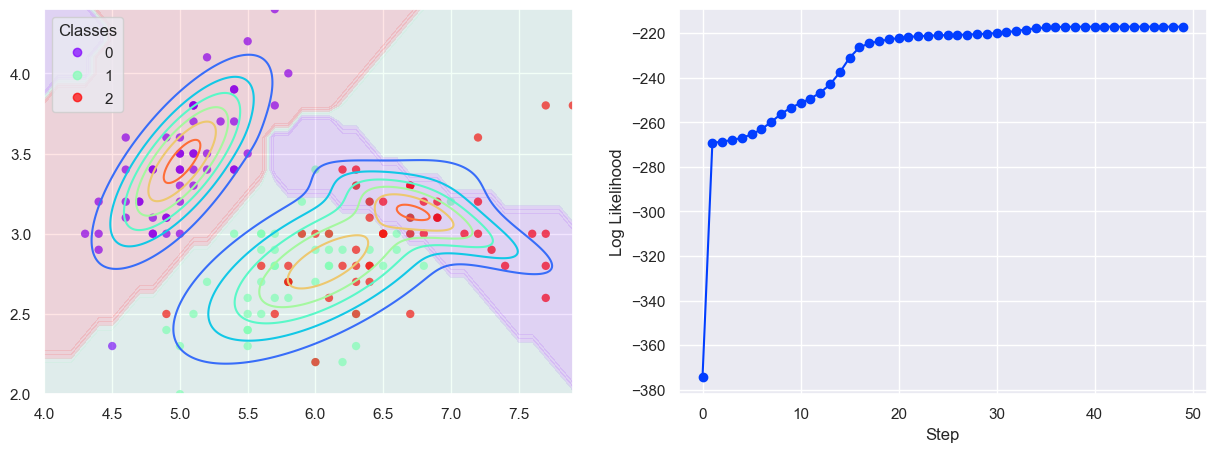

In [22]:
def create_animation(all_steps_em, data_x, iris_t):
    
    fig, (ax, ax2) = plt.subplots(1, 2, figsize=(15,5))
    
    log_likelihoods = list(map(lambda x: x[3], all_steps_em))
    
    def animate(i):
        ax.cla()
        ax2.cla()
        
        predictions = all_steps_em[i][4]
        
        plot1 = plot_gaussian_mixtures(all_steps_em[i][0], all_steps_em[i][1], all_steps_em[i][2], iris_x, iris_t, target=ax)
        
        plot_mesh(
            lambda x: nearest_centroid_based_class(x, all_steps_em[i][0], all_steps_em[i][1]),
            n_class=len(all_steps_em[i][0]), target=ax
        )
        
        ax2.plot(list(range(i)), log_likelihoods[:i], '-o')
        plt.xlabel('Step')
        plt.ylabel('Log Likelihood')
        return plot1
    
    anim = FuncAnimation(
        fig, animate,
        frames=len(all_steps_em), interval=500, blit=True
    )
    return HTML(anim.to_html5_video())

create_animation(all_steps_em, iris_x, iris_t)

## 2) Principal Component Analysis

### 2.1) Generate data

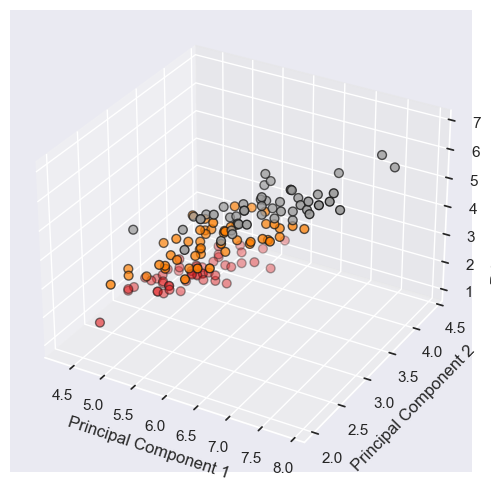

In [23]:
iris4_x = np.array(iris.data[:, :4])
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_classes_3d(data, classes):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')  # Use add_subplot with '3d' projection
    
    # Scatter plot in 3D
    scatter = ax.scatter(data[:, 0], data[:, 1], data[:, 2], 
                         c=classes, cmap=plt.cm.Set1, edgecolor='k', s=40)
    
    # Add labels to the axes
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    
    plt.show()
# Call the function to plot the data
plot_classes_3d(iris4_x[:, :3], iris_t)

### 2.3) Apply PCA

Implement

def pca_projection(data, components):


Purpose
Return the data projected onto the top components principal components (see Lecture 10 for method).

Inputs

data: NumPy array of shape (N, D) — N samples, D features.

components: int in [1, D] — number of components to keep.

Output

NumPy array of shape (N, components) — the projected data (same sample order).

In [24]:
def pca_projection(data, components):
    # Center the data
    data_meaned = data - np.mean(data, axis=0)
    
    # Compute covariance matrix
    cov_mat = np.cov(data_meaned, rowvar=False)
    
    # Eigen decomposition
    eigenvalues, eigenvectors = np.linalg.eigh(cov_mat)
    
    # Sort eigenvalues and corresponding eigenvectors
    sorted_index = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalues = eigenvalues[sorted_index]
    sorted_eigenvectors = eigenvectors[:, sorted_index]
    
    # Select the top 'components' eigenvectors
    eigenvector_subset = sorted_eigenvectors[:, :components]
    
    # Project the data onto the new feature space
    data_reduced = np.dot(data_meaned, eigenvector_subset)
    
    return data_reduced

### 2.4) Display projection

Projects the original 4-D Iris features to 2-D using PCA (PC1 vs PC2) and plots the result, coloring points by their true class labels with a legend.

(<matplotlib.collections.PathCollection at 0x1740e32c0>,
 <matplotlib.legend.Legend at 0x1756ca000>)

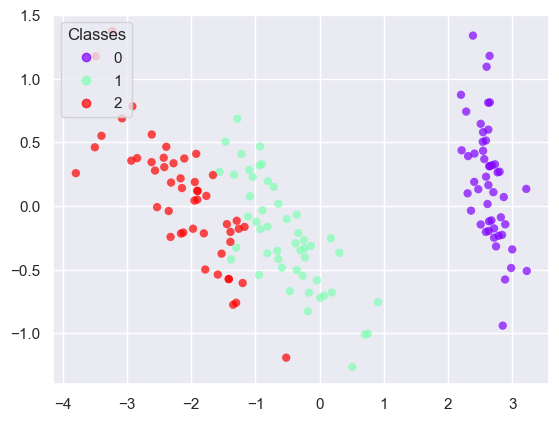

In [25]:
def plot_classes(data, classes, legend=True, target=plt):
    scatter = target.scatter(data[:, 0], data[:, 1], c=classes, alpha=0.7, cmap='rainbow', edgecolor='none')
    if legend:
        legend = target.legend(*scatter.legend_elements(), loc="upper left", title="Classes")
        return (scatter, legend)
    return (scatter, )

projected_data = pca_projection(iris4_x, 2)
plot_classes(projected_data, iris_t)

Projects the original 4-D Iris features to 3-D using PCA (PC1–PC3) and plots a 3D scatter of the projected points, colored by the true class labels.

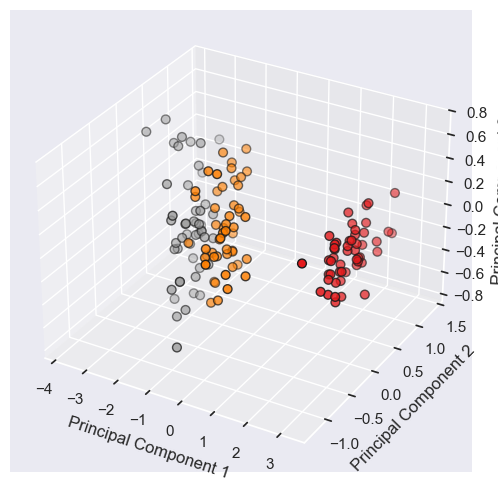

In [26]:
projected_data = pca_projection(iris4_x, 3)
plot_classes_3d(projected_data, iris_t)